In [1]:
import ipywidgets as widgets
from vidtimit_module import VidtimitModule
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import cv2 as cv
import numpy as np
import os
import dlib
import math
import imutils
import json
from imutils import face_utils
from pprint import pprint

In [2]:
vt = VidtimitModule()

In [3]:
def rect_to_bb(rect):
    # take a bounding predicted by dlib and convert it
    # to the format (x, y, w, h) as we would normally do
    # with OpenCV
    x = rect.left()
    y = rect.top()
    w = rect.right() - x
    h = rect.bottom() - y
    
    return x, y, w, h

In [4]:
# initialize dlib's face detector (HOG-based) and then create
# the facial landmark predictor
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("shape_predictors/shape_predictor_68_face_landmarks.dat")

#### Loop through all speakers and collect the mouth landmarks for the sa1 prompt

In [5]:
prompt = "sa2"
print(vt.get_prompt(prompt))
print("Frames:", len(vt.get_frames_of_prompt("fjas0", prompt)))

Don't ask me to carry an oily rag like that.
Frames: 83


In [6]:
out = widgets.Output()
display(out)

landmarks = dict()

speaker_sample = vt.all_speakers[:10]

for index, speaker in enumerate(speaker_sample):
    frames_location = vt.get_frames_folder(speaker, prompt)
    frames = vt.get_frames_of_prompt(speaker, prompt)
    
    landmarks[speaker] = list()
    
    rect_found = False

    for frame_index, frame in enumerate(frames):
        with out:
            out.clear_output()
            print("Speaker: {}/{} {}".format(index+1, len(speaker_sample), speaker))
            print("Frame: {}/{}".format(frame_index+1, len(frames)))

        # load the input image, resize it, and convert it to grayscale
        image = cv.imread(os.path.join(frames_location, frame))
        image = imutils.resize(image, width=500)
        gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)

        # detect faces in the grayscale image
        rects = detector(gray, 1)
        rect = rects[0]

        # Convert the location of the face to 
        x, y, w, h = rect_to_bb(rect)
        face = gray[y:y + h, x:x + w]

        # Determine the landmark for the region, then translate that to a coordinate in the picture
        shape = predictor(image, rect)
        shape = face_utils.shape_to_np(shape)[48:].T

        # x_input = list((shape[0]-x).astype(int))
        # y_input = list((shape[1]-y).astype(int))
        
        x_input = [int(i) for i in shape[0]-x]
        y_input = [int(i) for i in shape[1]-y]
        
        landmarks[speaker].append([x_input, y_input])
        
        # landmarks[speaker].append([list(shape[0]-x), list(shape[1]-y)])
# pprint(landmarks)

Output()

In [7]:
with open("landmarks_{}.json".format(prompt), "w") as landmarks_output:
    landmarks_output.write(json.dumps(landmarks, indent=1))

In [8]:
out = widgets.Output()
display(out)

# Coordinates for mouth points normalized
landmarks_n = dict()

# Will preserve ratio of points
respect_ratio = True

for index, speaker in enumerate(landmarks):
    landmarks_n[speaker] = list()
    
    with out:
        out.clear_output()
        print("Speaker: {}/{} {}".format(index+1, len(landmarks), speaker))
        
    # Loop through all coordinates and determine the boundary
    for coord_index, coords in enumerate(landmarks[speaker]):
        x_coords, y_coords = coords

        # Lower and upper bound
        x_bound = [math.inf, 0]
        y_bound = [math.inf, 0]

        # Check each edge of the boundary box
        if x_bound[0] > min(x_coords): x_bound[0] = min(x_coords)
        if x_bound[1] < max(x_coords): x_bound[1] = max(x_coords)
        if y_bound[0] > min(y_coords): y_bound[0] = min(y_coords)
        if y_bound[1] < max(y_coords): y_bound[1] = max(y_coords)

        # This is the local maximum, the max minus the min
        max_x = x_bound[1]-x_bound[0]
        max_y = y_bound[1]-y_bound[0]

        # Subtract the lower bound for each value so the minimum is at zero
        x_coords = np.subtract(x_coords, x_bound[0])
        y_coords = np.subtract(y_coords, y_bound[0])

        # Divide by the local maximum to normalize
        x_coords = x_coords / max_x
        y_coords = y_coords / max_y

        if respect_ratio:
            y_coords *= max_y / max_x
            
        # Store in the normalized series
        landmarks_n[speaker].append([list(x_coords), list(y_coords)])

# pprint(landmarks_n)

Output()

In [9]:
with open("landmarks_{}_normalized.json".format(prompt), "w") as landmarks_output:
    landmarks_output.write(json.dumps(landmarks_n, indent=1))

Output()

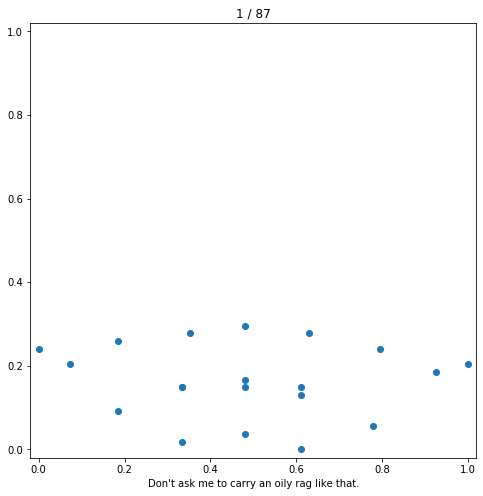

In [10]:
out = widgets.Output()
display(out)

series = list()

def animate(i):
    scatter.set_offsets(np.c_[series[i][0], series[i][1]])
    ax.set_title("{} / {}".format(i+1, len(series)))
    ax.set_xlabel(vt.get_prompt(prompt))

# Create the plot and set the limits
fig, ax = plt.subplots()
ax.set_xlim((-0.02, 1.02))
ax.set_ylim((-0.02, 1.02))
scatter = ax.scatter([], [])
    
for index, speaker in enumerate(landmarks_n):        
    out.clear_output()
    
    # Change the series for the animate function
    series = landmarks_n[speaker]

    # Create the animation
    anim = FuncAnimation(fig, animate, interval=100, frames=len(landmarks_n[speaker]))
    
    # Print to output widget
    with out:
        print(speaker)
        print("Speaker: {}/{} {}".format(index+1, len(landmarks_n), speaker))
        print("Animation has {} frames.".format(len(list(anim.new_frame_seq()))))
        print("Prompt has {} frames.".format(len(series)))

    # Save the animation in the appropriate folder and with an appropriate name
    anim.save("{prompt}_animations/{}-{prompt}.mp4".format(speaker, prompt=prompt))

In [11]:
"done"

'done'

#### Conclusions after thursday
1. Complete the Sentence Splitter
2. Ready for RNN after sentence splitter is done
3. Respect ratio set to False